In [1]:
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import seaborn as sns

from dredFISH.Utils import basicu

In [2]:
sns.set_context('talk')

In [3]:
f = '../data_dump/counts/P28_nr_allcells_Oct24.h5ad'
adata_nr = anndata.read(f)
adata_nr

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 23930 × 53547
    obs: 'cov', 'covfactor', 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'Class_broad', 'sample', 'Type', 'Subclass'
    var: 'id'

In [4]:
f = '../data_dump/counts/P28_dr_allcells_Oct25.h5ad'
adata_dr = anndata.read(f)
adata_dr

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 24816 × 53547
    obs: 'cov', 'covfactor', 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'Type', 'Subclass'
    var: 'id'

In [5]:
adata_nr.obs['Subclass'].unique()

['L6CT', 'L4', 'L2/3', 'L5PT', 'L6IT', ..., 'Micro', 'Endo', 'Astro', 'OPC', 'VLMC']
Length: 20
Categories (20, object): ['Astro', 'Endo', 'Frem1', 'L2/3', ..., 'Sst', 'Stac', 'VLMC', 'Vip']

In [6]:
adata_dr.obs['Subclass'].unique()

['L4', 'L2/3', 'L5NP', 'L6IT', 'L5IT', ..., 'Astro', 'OD', 'Micro', 'Endo', 'VLMC']
Length: 20
Categories (20, object): ['Astro', 'Endo', 'Frem1', 'L2/3', ..., 'Sst', 'Stac', 'VLMC', 'Vip']

In [7]:
nr_types = np.sort(adata_nr.obs['Subclass'].unique().astype(str))
nr_types

array(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT',
       'L6CT', 'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb',
       'Sst', 'Stac', 'VLMC', 'Vip'], dtype='<U5')

In [8]:
dr_types = np.sort(adata_dr.obs['Subclass'].unique().astype(str))
dr_types

array(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT',
       'L6CT', 'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb',
       'Sst', 'Stac', 'VLMC', 'Vip'], dtype='<U5')

In [9]:
nr_types == dr_types

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [10]:
def get_normed_bulks(mat, genes, types):
    """
    - select expressed genes
    - sparse to dense
    - merge cells to clusters
    - log10(CPM+1) norm bulk samples
    """
    ncell, ngene = mat.shape
    cellcov = np.asarray(mat.sum(axis=1)).reshape(-1,)
    genecov = np.asarray(mat.sum(axis=0)).reshape(-1,)
    cond = genecov>ncell*0.01 # expressed in at least 1% of cells
    matsub = np.asarray(mat[:,cond].todense())
    
    # pseudo-bulk samples -- pull counts from cells
    Xk, xclsts = basicu.group_sum(matsub, types)
    ck, xclsts = basicu.group_sum(cellcov.reshape(-1,1), types)
    Xk = np.log10(1+(np.array(Xk)/np.array(ck))*1e6) # log10(1+CPM)
    df = pd.DataFrame(Xk, index=xclsts, columns=genes[cond])
    return df.T # gene by types 

def get_normed_bulks_for_adata_by_types(adata, typecol='Type'):
    """
    """
    return get_normed_bulks(adata.X.copy(), adata.var.index.values, adata.obs[typecol])

In [11]:
adata_nr.obs['biosample'] = adata_nr.obs['sample'].apply(lambda x: x[:-1])
adata_dr.obs['biosample'] = adata_dr.obs['sample'].apply(lambda x: x[:-1])

In [12]:
adata_nr.obs['sample'].unique()

['P28_1a', 'P28_1b', 'P28_2a', 'P28_2b']
Categories (4, object): ['P28_1a', 'P28_1b', 'P28_2a', 'P28_2b']

In [13]:
samples_nr = np.unique(adata_nr.obs['biosample'])
samples_dr = np.unique(adata_dr.obs['biosample'])
samples_nr, samples_dr

(array(['P28_1', 'P28_2'], dtype=object),
 array(['P28_dr_1', 'P28_dr_3'], dtype=object))

In [14]:
%%time
dfs_nr = []
for samp in samples_nr:
    adatasub = adata_nr[adata_nr.obs['biosample']==samp]
    df = get_normed_bulks_for_adata_by_types(adatasub, typecol='Subclass')
    print(df.shape)
    print(df.columns)
    dfs_nr.append(df)

dfs_dr = []
for samp in samples_dr:
    adatasub = adata_dr[adata_dr.obs['biosample']==samp]
    df = get_normed_bulks_for_adata_by_types(adatasub, typecol='Subclass')
    print(df.shape)
    print(df.columns)
    dfs_dr.append(df)
    

(15727, 20)
Index(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT', 'L6CT',
       'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb', 'Sst', 'Stac',
       'VLMC', 'Vip'],
      dtype='object')
(15295, 20)
Index(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT', 'L6CT',
       'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb', 'Sst', 'Stac',
       'VLMC', 'Vip'],
      dtype='object')
(15643, 20)
Index(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT', 'L6CT',
       'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb', 'Sst', 'Stac',
       'VLMC', 'Vip'],
      dtype='object')
(14833, 20)
Index(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT', 'L6CT',
       'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb', 'Sst', 'Stac',
       'VLMC', 'Vip'],
      dtype='object')
CPU times: user 4.37 s, sys: 5.27 s, total: 9.63 s
Wall time: 9.62 s


In [15]:
genes_comm = adata_nr.var.index.values
for df in dfs_nr:
    genes_comm = np.intersect1d(genes_comm, df.index.values)
    print(genes_comm.shape)
for df in dfs_dr:
    genes_comm = np.intersect1d(genes_comm, df.index.values)
    print(genes_comm.shape)
    
for i in range(2):
    dfs_nr[i] = dfs_nr[i].loc[genes_comm]
    dfs_dr[i] = dfs_dr[i].loc[genes_comm]

(15727,)
(14961,)
(14683,)
(14376,)


In [16]:
# # check
# for df in dfs_nr:
#     print(df.shape, df.columns.values)
# for df in dfs_dr:
#     print(df.shape, df.columns.values)

In [17]:
tensor_nr = np.stack(dfs_nr, axis=2)
tensor_dr = np.stack(dfs_dr, axis=2)
tensor_nr.shape, tensor_dr.shape

((14376, 20, 2), (14376, 20, 2))

In [18]:
# for each gene and cell type; 4 rep vs 4 rep - t-test and p-val correction 
lfc = np.mean(tensor_dr, axis=2) - np.mean(tensor_nr, axis=2) # log10FC (log10CPM as raw counts)
maxexp = np.maximum(np.mean(tensor_dr, axis=2), np.mean(tensor_nr, axis=2)) # max log10CPM (out of the 4 numbers)
minexp = np.minimum(np.mean(tensor_dr, axis=2), np.mean(tensor_nr, axis=2)) # min log10CPM (out of the 4 numbers)
ts, ps = ttest_ind(tensor_nr, tensor_dr, axis=2)
rejs, qs, _, _ = multipletests(np.nan_to_num(ps, 1).reshape(-1,), method='fdr_bh')
rejs = rejs.reshape(ps.shape)
qs = qs.reshape(ps.shape)

In [19]:
lfc.shape, rejs.shape, qs.shape, np.sum(np.sum(rejs, axis=1) > 0), np.sum(rejs, axis=0) 

((14376, 20),
 (14376, 20),
 (14376, 20),
 1901,
 array([  29,  183,  279,   24,   10,   19,   83,   13,   11,   17,  121,
         105,  121,   33,   35,   29,   25, 1313,  246,  112]))

In [46]:
fc = 1.2
cond1 = rejs # FDR< 0.05
cond2 = np.abs(lfc) > np.log10(fc) # FC>2
cond2up = lfc >  np.log10(fc) # FC>2
cond2dn = lfc < -np.log10(fc) # FC>2
cond3 = minexp > np.log10(1+1) # maxexp CPM>1

sigsigs = np.all([cond1, cond2, cond3], axis=0)
sigsigs.shape, np.sum(np.sum(sigsigs, axis=1) > 0), np.sum(sigsigs, axis=0)

((14376, 20),
 138,
 array([16,  5, 10, 20,  6, 12,  6,  9,  7,  8, 10,  5,  3,  5,  4,  1,  5,
         2,  4,  3]))

In [47]:
sigsigs_up = np.all([cond1, cond2up, cond3], axis=0)
sigsigs_up.shape, np.sum(np.sum(sigsigs_up, axis=1) > 0), np.sum(sigsigs_up, axis=0)

((14376, 20),
 46,
 array([5, 3, 1, 6, 0, 1, 1, 3, 4, 2, 6, 3, 0, 1, 2, 0, 2, 2, 3, 1]))

In [48]:
sigsigs_dn = np.all([cond1, cond2dn, cond3], axis=0)
sigsigs_dn.shape, np.sum(np.sum(sigsigs_dn, axis=1) > 0), np.sum(sigsigs_dn, axis=0)

((14376, 20),
 92,
 array([11,  2,  9, 14,  6, 11,  5,  6,  3,  6,  4,  2,  3,  4,  2,  1,  3,
         0,  1,  2]))

In [49]:
# show results
unq_types = dfs_nr[0].columns.values
sigsum = pd.DataFrame(index=unq_types)
sigsum['DR_up'] = np.sum(sigsigs_up, axis=0)
sigsum['DR_dn'] = np.sum(sigsigs_dn, axis=0)
sigsum

,DR_up,DR_dn
Astro,5,11
Endo,3,2
Frem1,1,9
L2/3,6,14
L4,0,6
L5IT,1,11
L5NP,1,5
L5PT,3,6
L6CT,4,3
L6IT,2,6


In [50]:
def extract_res_onetype(idx):
    return genes_comm[sigsigs_up[:,idx]], genes_comm[sigsigs_dn[:,idx]]

In [51]:
def show_onetype(idx):
    """
    """
    a = tensor_nr[sigsigs_up[:,idx],idx,:] 
    b = tensor_dr[sigsigs_up[:,idx],idx,:] 
    ab = np.hstack([a,b])

    a = tensor_nr[sigsigs_dn[:,idx],idx,:] 
    b = tensor_dr[sigsigs_dn[:,idx],idx,:] 
    ab2 = np.hstack([a,b])
    ab = np.vstack([ab,ab2])

    ab = (ab - np.mean(ab, axis=1).reshape(-1,1)) #/np.std(ab, axis=1).reshape(-1,1)
    _genes = genes_comm[np.logical_or(sigsigs_up[:,idx], sigsigs_dn[:,idx])]
    ab = pd.DataFrame(ab, 
                      index=_genes, 
                      columns=np.hstack([samples_nr, samples_dr]),
                     )
    
    fig, ax = plt.subplots(figsize=(2, min(6, 0.3*len(ab))))
    sns.heatmap(ab, center=0, cmap='coolwarm', yticklabels=True, cbar_kws=dict(shrink=0.5, label='log10 FC'))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(unq_types[idx])
    plt.show()

In [52]:
sigsum_genes = sigsum.copy()
ups = []
dns = []
for i, (_type, row) in enumerate(sigsum.iterrows()):
    _up, _dn = extract_res_onetype(i)
    ups.append(", ".join(_up))
    dns.append(", ".join(_dn))
    
sigsum_genes['genes_up'] = ups 
sigsum_genes['genes_dn'] = dns 
sigsum_genes

,DR_up,DR_dn,genes_up,genes_dn
Astro,5,11,"Cep120, Colec12, Pgm5, Slc22a15, Sox2ot","Cdkn1a, E4f1, Fgfr3, Gm10767, Gm16124, Mafg, M..."
Endo,3,2,"Tbrg4, Tex2, Tmem63c","Slc39a2, Zfp366"
Frem1,1,9,Polr2k,"3110082I17Rik, 4930586N03Rik, Col24a1, Drc3, G..."
L2/3,6,14,"Clcn3, Dusp14, Gtf2b, Mpzl1, Nfia, Rabgef1","Aatf, Agps, Anapc4, Bivm, Bmpr1b, Epb41l4b, Gm..."
L4,0,6,,"Asb11, Dsel, Lmbr1, Lrpprc, Myo19, Tsen15"
L5IT,1,11,Vmp1,"2810032G03Rik, Adal, Cers4, Fbxo18, Klhl20, Nq..."
L5NP,1,5,Gm26760,"4930570G19Rik, Acaca, Dgcr8, Gm37986, Neurl1b"
L5PT,3,6,"Nr1d2, Sash1, Ube2d3","Gm15155, Gm20537, Nupl2, Scube1, Zfp236, Zfp715"
L6CT,4,3,"Arih2, Col8a1, Slc24a4, Slco3a1","Fntb, Ncoa5, Neu2"
L6IT,2,6,"Bdnf, Egfem1","Entpd5, Ncoa7, Ppp1r42, Trmt10b, Vps39, Zfp697"


In [53]:
types_order = [
    'L2/3', 
    'L4', 
    'L5IT', 
    'L6IT', 
    'L5PT', 
    'L5NP', 
    'L6CT', 
    'L6b',
    
    'Pvalb', 
    'Sst', 
    'Vip',
    'Lamp5', 
    
    'Stac', 
    'Frem1', 
    
    'Astro', 
    'OD', 
    'OPC',
    'Micro', 
    'Endo', 
    'VLMC', 
]


In [54]:
dfres = sigsum_genes.loc[types_order].copy()
dfres
# dfres.to_csv('../results/P28_NR_DR_DEGs_Oct27.csv', header=True, index=True)

,DR_up,DR_dn,genes_up,genes_dn
L2/3,6,14,"Clcn3, Dusp14, Gtf2b, Mpzl1, Nfia, Rabgef1","Aatf, Agps, Anapc4, Bivm, Bmpr1b, Epb41l4b, Gm..."
L4,0,6,,"Asb11, Dsel, Lmbr1, Lrpprc, Myo19, Tsen15"
L5IT,1,11,Vmp1,"2810032G03Rik, Adal, Cers4, Fbxo18, Klhl20, Nq..."
L6IT,2,6,"Bdnf, Egfem1","Entpd5, Ncoa7, Ppp1r42, Trmt10b, Vps39, Zfp697"
L5PT,3,6,"Nr1d2, Sash1, Ube2d3","Gm15155, Gm20537, Nupl2, Scube1, Zfp236, Zfp715"
L5NP,1,5,Gm26760,"4930570G19Rik, Acaca, Dgcr8, Gm37986, Neurl1b"
L6CT,4,3,"Arih2, Col8a1, Slc24a4, Slco3a1","Fntb, Ncoa5, Neu2"
L6b,6,4,"3110083C13Rik, Cbfb, Dnajc4, Hkdc1, Mfap1b, Tb...","Pkib, Slc46a2, Spx, Wdr17"
Pvalb,0,1,,Rbck1
Sst,2,3,"Kpna1, Snap25","Adck2, Ggt7, Pus7"


In [55]:
dfplot = sigsum_genes.loc[types_order].iloc[:,:2].copy()

Text(0, 0.5, 'Number of DE genes \n (FDR<0.05, FC > 2, max CPM > 1)')

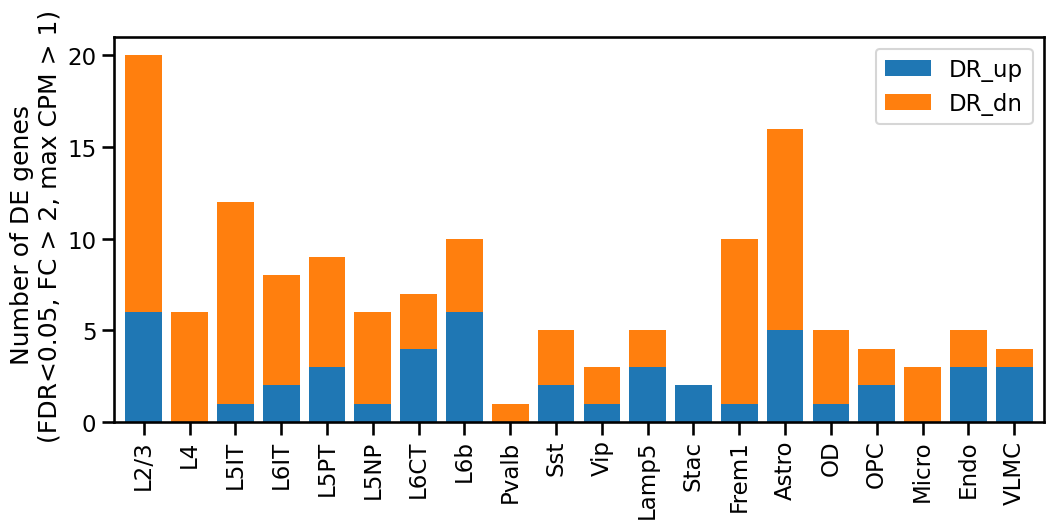

In [56]:
fig, ax = plt.subplots(figsize=(12,5))
dfplot.plot.bar(stacked=True, width=0.8, ax=ax)
# ax.vlines(-0.5+np.array([3, 16, 20, 25, 28, 31, 33, 38, 39]), ymin=0, ymax=50, color='lightgray', linestyle='--', linewidth=1)
ax.set_ylabel('Number of DE genes \n (FDR<0.05, FC > 2, max CPM > 1)')

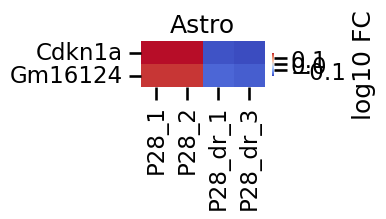

In [31]:
show_onetype(0)

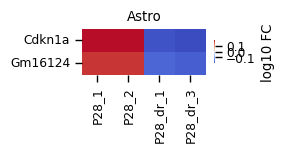

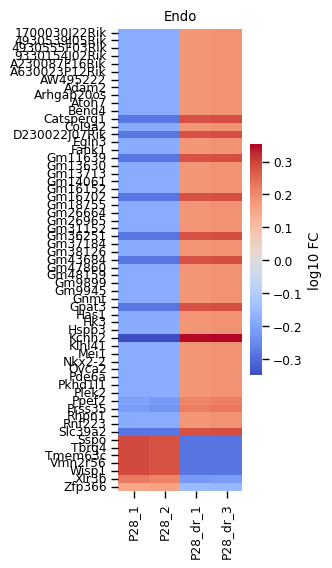

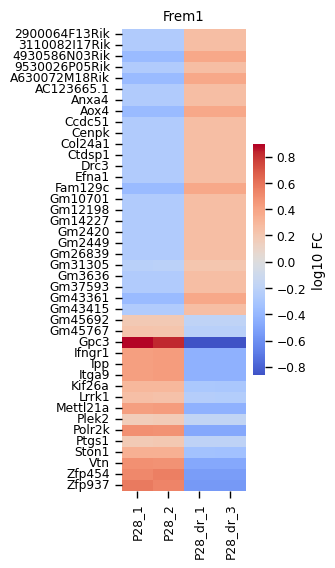

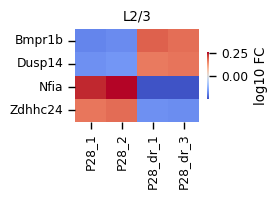

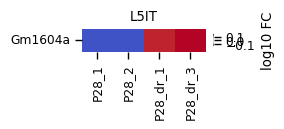

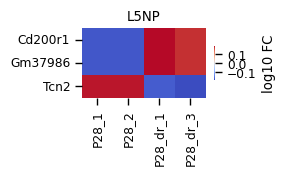

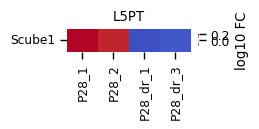

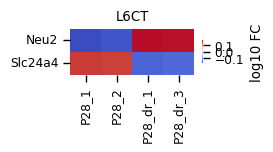

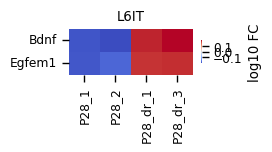

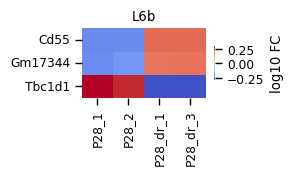

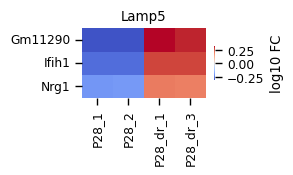

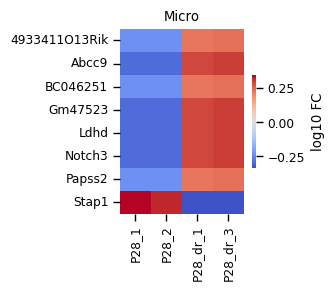

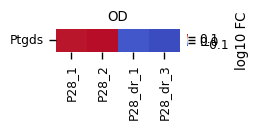

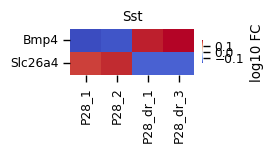

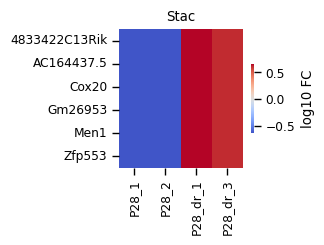

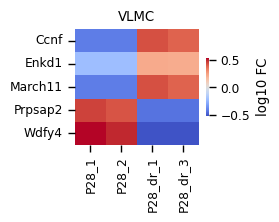

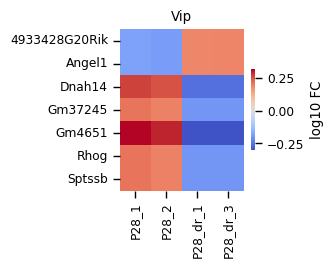

In [32]:
with sns.plotting_context('paper'):
    for i, (_type, row) in enumerate(sigsum.iterrows()):
        if row.sum() > 0:
            show_onetype(i)

In [33]:
# focus on non cells
# read the cell paper Methods?